In [249]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import plotly.express as px
import lightgbm as lgb
from catboost import CatBoostRegressor
!pip install optuna
import optuna  
from optuna.integration import LightGBMPruningCallback



In [219]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


No missing values

In [221]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Starts from 2018-03-01 00:00:00

In [222]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


End at 2018-08-31 23:00:00

Let's break the orders into one contribute to the trend, seasonality and general noise 

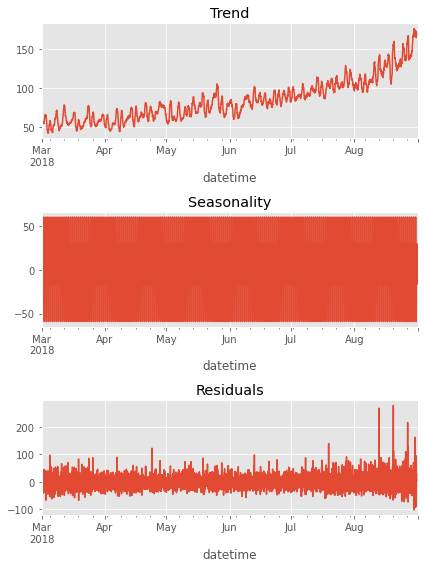

In [223]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

There is a obvious trend of increasing number of order in this period. The residuals stays almost the same. With Seasonality we have problem with this time sample. I guess that by sampeling shorter period we might learn more. I will take half month  

<AxesSubplot:xlabel='datetime'>

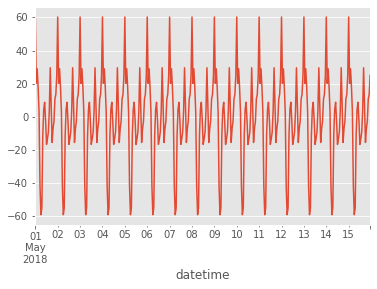

In [224]:
new_data = decomposed.seasonal['2018-05-01':'2018-05-15']
new_data.plot()

Now it looks more obvious. I will try 3 days to make it clearer

In [225]:
new_data = decomposed.seasonal['2018-05-01':'2018-05-03']
px.line(new_data).show()

We can see the highest peak of orders is at midnight. Second high peak is afternoon by 4 PM. Then at 10 AM . And the lowest time is 6 AM

Now let's check the rolling mean and std of orders during this time

<AxesSubplot:xlabel='datetime'>

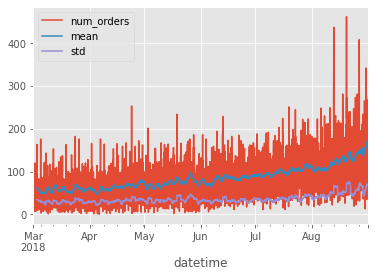

In [226]:
new_data = data.copy(deep=True)
new_data['mean'] = data['num_orders'].rolling(50).mean()
new_data['std'] = data['num_orders'].rolling(50).std()
new_data.plot() 

By the end of this period in august we can see an increase in orders amount and also higher variance

In [227]:
# Creating features
def make_features(df, max_lag, rolling_mean_size_hour, rolling_mean_size_day):
    column_heading = df.columns[0] 
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df[column_heading].shift(lag)

    df['rolling_mean_hour'] = df[column_heading].shift().rolling(rolling_mean_size_hour).mean()
    df['rolling_mean_day'] = df[column_heading].shift().rolling(rolling_mean_size_day).mean()

make_features(data, 5, 2, 24)
data

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean_hour,rolling_mean_day
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,104.5,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,78.0,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,68.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,212.0,164.875000
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,171.5,167.541667
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,145.0,168.041667


In [228]:
# remove the nan cause by lag and rolling mean in the dataset beggining
data.dropna(inplace=True)

In [229]:
# Split train and test 
X = data.drop(['num_orders'], axis=1)
y = data[['num_orders']]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3952, 11), (440, 11), (3952, 1), (440, 1))

ok

Linear Regression

In [230]:
lr = LinearRegression()
lr.fit(X_train, y_train)

predict = lr.predict(X_test)

print("RMSE for the test set: ", mean_squared_error(y_test, predict)**0.5)

RMSE for the test set:  51.15902132212116


For simple Linear Regression the target RMSE of 48 not achieved

Let's try light GBM

# laoding data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [258]:
%%time

lgbm_regressor = lgb.LGBMRegressor(
    boosting_type='gbdt',
    learning_rate=0.1,
    n_estimators=10000,
    random_state=12345
)

lgbm_regressor.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='RMSE',
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

y_predict = lgbm_regressor.predict(X_test)
print(f"LightGBM RMSE on the test set: {lgbm_regressor.best_score_['valid_0']['rmse']:.2f}")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 42.33	valid_0's l2: 1791.82
LightGBM RMSE on the test set: 42.33
Wall time: 150 ms


With light GBM the RMSE is lower then 48

Now let's do the same but this time optimise the parameters: learning_rate, num_leaves and max_depth

In [244]:
def objective(trial, X, y):
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
    }
    
    model = lgb.LGBMRegressor(**param_grid)
    model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="rmse",
            early_stopping_rounds=100,
            callbacks=[lgb.early_stopping(stopping_rounds=100)]  # Add a pruning callback
        )
    preds = model.predict(X_test)
    score = mean_squared_error(y_test, preds)**0.5
        
    return score

In [262]:
%%time

study = optuna.create_study(direction="minimize", study_name="LGBM regressor")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 43.3757	valid_0's l2: 1881.45
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 43.0679	valid_0's l2: 1854.85
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	valid_0's rmse: 41.5111	valid_0's l2: 1723.17
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 42.2609	valid_0's l2: 1785.99
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's rmse: 42.7928	valid_0's l2: 1831.22
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's rmse: 42.43	valid_0's l2: 1800.31
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 

In [256]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 42.08295
	Best params:
		n_estimators: 10000
		learning_rate: 0.17711320269098396
		num_leaves: 80
		max_depth: 11


I managed to squeezed up a bit the RMSE score and now it's almost 42! 

For conclusion the hyperparameter tuning on the lgbm yield the best results. This together with optimizing the features I managed to get a good RMSE, much below the requirements